# Instructions

- read the whole page once before starting to answer questions
- keep the first theoretical question (Epsilon first) as a homework (send it to me later)
- do the rest during the practical session
- you can work in groups (up to 3 students)
- send your completed notebook to e.diemert@criteo.com

# Study of Epsilon-first (theory)

Here is a new policy: Epsilon-first. 

Algorithm:
- parameter: $\epsilon \in [0,1]$
- for $n \epsilon$ rounds, play random actions, uniformly
- then play $\operatorname{argmax}_{i} \bar{X}_i$ until the end

### Questions (4 points)
Suppose we are in a stochastic game with 2 Bernoulli arms and of duration $n$ turns.
- Use Hoeffding's inequality to compute a lower bound on $\tilde{n}$, the number of samples needed to detect a given $\Delta = \mu_i^* - \mu_i$
- write the expected, instantaneous regret $R^-(t)$ at each round before we switch to exploitation
- write the expected, instantaneous regret $R^+(t)$ after we switch to exploitation
- write the total regret $R_n(\epsilon, \delta)$ at the end of the game

Your answers

#### Optional reading
- A more detailed investigation of this family of policies (aka Explore Than Commit) can be found [here](http://banditalgs.com/2016/09/14/first-steps-explore-then-commit/)
- An extension of this idea can be found [here](https://arxiv.org/pdf/1505.00369.pdf)

# Dataset

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
%cat data/univ-latencies/license.txt

In [2]:
df = pd.read_csv('data/univ-latencies/univ-latencies.txt')

In [4]:
print("Latency of some homepages in the first timesteps")
df.iloc[:10,:5]

Latency of some homepages in the first timesteps


,acu-edu,acadiau-ca,adrian-edu,agnesscott-edu,aims-edu
0,396,381,488,506,333
1,271,261,488,504,276
2,271,141,325,545,266
3,268,136,324,1946,331
4,273,136,321,549,290
5,268,144,543,545,284
6,271,142,290,472,275
7,316,136,339,2162,372
8,268,136,286,464,263
9,531,409,320,470,315


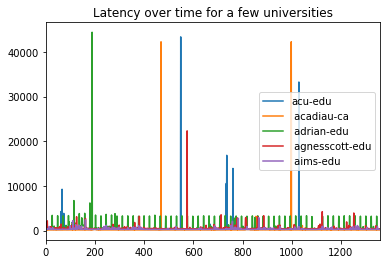

In [5]:
df.iloc[:,:5].plot(title='Latency over time for a few universities')

The dataset is transformed so as to come back to a Bernoulli problem. The reward is:
- 1 if latency is < threshold
- 0 if latency is > threshold

for an arbitrary latency threshold.

The task boils down to exploring which universities have the lowest latency and exploiting this knowledge to minimize the sum of latencies until the end of the experiment.

In [6]:
print("Mean reward for a few arms")
(df.iloc[:,:5] > 500).astype(int).mean()

Mean reward for a few arms


acu-edu            0.021308
 acadiau-ca        0.016899
 adrian-edu        0.131521
 agnesscott-edu    0.146216
 aims-edu          0.069067
dtype: float64

In [13]:
def get_dataset(n_arms, n_steps=None, max_latency=None, quantile=.5, shuffle=True):
    """
    return a binary dataset.
    
    n_arms: nb of pullable arms
    max_latency: criteria to decide if latency is good/bad (default: inferred from quantile)
    quantile: proportion of "1" labels
    """
    df = pd.read_csv('data/univ-latencies/univ-latencies.txt')
    if n_arms > df.shape[1]:
        raise Exception("Please specify max %d arms" % df.shape[1])
    if max_latency is None:
        max_latency = df.iloc[:,:n_arms].mean().quantile(quantile)
    raw_vector = (df.iloc[:,:n_arms] < max_latency).astype(int)
    if shuffle:
        raw_vector = raw_vector.sample(frac=1)
    if n_steps is None:
        return raw_vector
    if raw_vector.shape[0] > n_steps:
        return raw_vector.iloc[:n_steps-1,:]
    v = raw_vector.sample(n=n_steps, replace=True, random_state=42)
    v.index = np.arange(v.shape[0])
    return v

In [51]:
def adversarialize(ddf, nb_episods=2):
    ddf = ddf.copy()
    episod_len = int(ddf.shape[0]/nb_episods)
    #print("len", ddf.shape[0], "epilen", episod_len)
    for _ in range(nb_episods):
        start = _*episod_len
        end = min((_+1)*episod_len, ddf.shape[0])
        #print("epi", _, start, end)
        for col in range(ddf.shape[1]):
            ddf.iloc[start:end,col] = np.sort(ddf.iloc[start:end,col])
            if np.random.randint(0,2) > 0:
                ddf.iloc[start:end,col] = np.flip(ddf.iloc[start:end,col])
    ddf.index = np.arange(ddf.shape[0])
    return ddf

In [60]:
get_dataset(5, quantile=.5).mean()

acu-edu            0.964732
 acadiau-ca        0.980162
 adrian-edu        0.788391
 agnesscott-edu    0.467303
 aims-edu          0.907421
dtype: float64

# Algorithms

## Bandit API

In [30]:
class Bandit():
    def __init__(self, n_arms):
        self.n_arms = n_arms
    def pull(self) -> int:
        """Choose an arm."""
        raise NotImplemented()
    def feedback(self, arm: int, reward):
        """Process feedback"""
        raise NotImplemented()

In [31]:
def test_API(bandit_class):
    bandit = bandit_class(2)
    arm = bandit.pull()
    assert type(arm) in (int, np.int, np.int16, np.int32, np.int64), type(arm)
    bandit.feedback(0, 0)
    bandit.feedback(0, 1)
    bandit.feedback(1, 0)
    bandit.feedback(1, 1)
    print(bandit_class.__name__ + " sounds correct.")

## Given Bandit Implems

In [32]:
class EpsilonGreedy(Bandit):
    def __init__(self, n_arms, epsilon=.1):
        Bandit.__init__(self, n_arms)
        self.epsilon = epsilon
        self.reward_sum_per_arm = np.zeros(n_arms)
        self.actions_per_arm = np.zeros(n_arms)
    def pull(self) -> int:
        unpulled_arms = [_ for _ in range(self.n_arms) if self.actions_per_arm[_] < 1]
        if len(unpulled_arms):
            return np.random.choice(unpulled_arms)
        if np.random.random() < self.epsilon:
            arm = np.random.choice(np.arange(self.n_arms))
            return arm
        arms_weights = self.reward_sum_per_arm / self.actions_per_arm
        return np.argmax(arms_weights)
    def feedback(self, arm: int, reward):
        self.actions_per_arm[arm] += 1
        self.reward_sum_per_arm[arm] += reward

In [33]:
test_API(EpsilonGreedy)

EpsilonGreedy sounds correct.


In [34]:
class WeightedRandomBandit(Bandit):
    """Play a random action according to $\hat{X_{i,t}}$."""
    def __init__(self, n_arms):
        Bandit.__init__(self, n_arms)
        self.reward_sum_per_arm = np.zeros(n_arms)
        self.actions_per_arm = np.zeros(n_arms)        
    def pull(self) -> int:
        unpulled_arms = [_ for _ in range(self.n_arms) if self.actions_per_arm[_] < 10]
        if len(unpulled_arms):
            return np.random.choice(unpulled_arms)
        arms_weights = self.reward_sum_per_arm / self.actions_per_arm
        arms_weights = arms_weights / np.sum(arms_weights)
        return np.random.choice(self.n_arms, p=arms_weights)
    def feedback(self, arm: int, reward):
        self.actions_per_arm[arm] = self.actions_per_arm[arm] + 1
        self.reward_sum_per_arm[arm] = self.reward_sum_per_arm[arm] + reward

In [35]:
test_API(WeightedRandomBandit)

WeightedRandomBandit sounds correct.


### Question: Implement a more elaborate bandit (4 pts)

- Choose one algorithm among (UCB, Thompson Sampling and, optionally, EXP3)
- Implement it using the Bandit API defined above
- Validate it using `test_API()`

In [15]:
class MyBandit(Bandit):
    def __init__(self, n_arms):
        pass
    def pull(self) -> int:
        return 0
    def feedback(self, arm: int, reward):
        pass

In [16]:
test_API(MyBandit)

MyBandit sounds correct.


# Evaluation

This class is mainly a helper to analyze the behavior of different bandit algorithms.

You may extend it if you want additional insight into an algorithm behavior.

In [74]:
class Experiment():
    """Given a Bandit, run an experiment and compute regret."""
    
    def __init__(self, n_arms:int, n_steps:int, adversarial:int=0):
        # data
        self.n_arms = n_arms
        self.data = get_dataset(n_arms, n_steps=n_steps)
        if adversarial > 0:
            self.data = adversarialize(self.data, nb_episods=adversarial)
        self.n_turns = self.data.shape[0]
        # regret analysis variables
        self.actions = []
        self.rewards = []
        self.stochastic_regrets = []
        # algo analysis variables
        self.actions_per_arm = np.zeros(self.n_arms)
        self.reward_sum_per_arm = np.zeros(self.n_arms)
        self.exploration = []
        
    def run(self, b: Bandit):
        for t in range(self.data.shape[0]):
            # bandit action
            chosen_arm = b.pull()
            reward = self.data.iloc[t, chosen_arm]
            b.feedback(chosen_arm, reward)
            # regret data gathering
            self.actions += [chosen_arm]
            self.actions_per_arm[chosen_arm] += 1
            self.rewards += [reward]
            self.stochastic_regrets += [self.data.iloc[t,self.best_arm] - reward]
            # algo data gathering
            self.reward_sum_per_arm[chosen_arm] += reward
            arms_perceived_performance = self.reward_sum_per_arm / (self.actions_per_arm + 1e-9)
            best_looking_arm = np.argmax(arms_perceived_performance)
            is_exploration = 0 if np.abs(arms_perceived_performance[best_looking_arm] - arms_perceived_performance[chosen_arm]) < 1e-5 else 1
            self.exploration += [is_exploration]
        return self
            
    # Regret metrics
    
    @property
    def best_arm(self):
        return np.argmax(self.data.mean().values)
    
    @property
    def worst_arm(self):
        return np.argmin(self.data.mean().values)

    @property
    def delta_perf(self):
        return self.data.iloc[:,self.best_arm].mean() - self.data.iloc[:,self.worst_arm].mean()
    
    @property
    def best_arm_cumulated_reward(self):
        return self.data.iloc[:,self.best_arm].sum()

    @property
    def best_arm_mean_reward(self):
        return self.data.iloc[:,self.best_arm].mean()
    
    @property
    def cumulated_stochastic_regret(self):
        return self.best_arm_cumulated_reward - np.sum(self.reward_sum_per_arm)
    
    @property
    def mean_reward(self):
        return np.mean(self.rewards)

    @property
    def mean_stochastic_regret(self):
        return self.best_arm_mean_reward - self.mean_reward

    @property
    def n_exploration_pulls(self):
        return np.sum(self.exploration)

    @property
    def exploration_pull_ratio(self):
        return self.n_exploration_pulls / float(self.n_turns)

    def stochastic_regret_summary(self):
        return pd.DataFrame(data={
                'E[R]': [self.mean_stochastic_regret],
                'E[Delta]': [self.delta_perf],
                'Rn': [self.cumulated_stochastic_regret],
            })
    
    def cumulated_regret_summary(self):
        rng = pd.date_range('1/1/2011', periods=len(self.stochastic_regrets), freq='600s')
        ts = pd.DataFrame(data={
                'cumulated_stochastic_regret': np.cumsum(self.stochastic_regrets), 
                'cumulated_exploration': np.cumsum(self.exploration), 
            }, index=rng)
        return ts
    
    # algorithm metrics
    
    def arm_plays_summary(self):
        true_means = self.data.mean()
        comp = pd.DataFrame(pd.concat([
                    true_means, 
                    pd.Series(self.actions_per_arm, index=true_means.index),
                    pd.Series(self.reward_sum_per_arm/self.actions_per_arm, index=true_means.index),
                ], axis=1).values, columns=['true_mean_reward', 'pull_count', 'observed_mean_reward'])
        return comp.sort_values(by='true_mean_reward')

# Experiments

## Run one bandit game

In [37]:
n_arms=10
n_steps=1000
exp = Experiment(n_arms, n_steps).run(EpsilonGreedy(n_arms))
exp.stochastic_regret_summary()

,E[R],E[Delta],Rn
0,0.051051,0.990991,51.0


In [57]:
n_arms=10
n_steps=1000
exp = Experiment(n_arms, n_steps, adversarial=True).run(EpsilonGreedy(n_arms))
exp.stochastic_regret_summary()

,E[R],E[Delta],Rn
0,0.034034,0.991992,34.0


### Question (2 points)
- run the same with your bandit class to check everything is fine
- compare regret with the one of E-greedy
- repeat and comment on what you observe; is it expected ?

In [19]:
# your code

your comments

## Experiment with regret of E-greedy

### Questions (4 points)
- run the following code once; what can you say about the optimal $\epsilon$ ?
- run it many times, is it stable ?
- change the number of arms; is the optimal $\epsilon$ constant ?
- give an interpretation of the behavior you observe

Text(0, 0.5, 'E[R]')

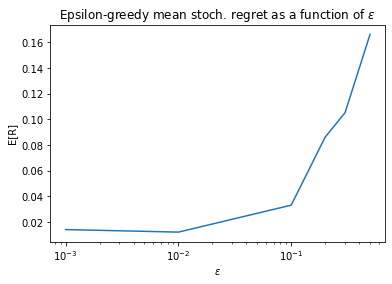

In [58]:
n_arms=10
n_steps=1000
epsilons = [.001, .01, .1, .2, .3, .5]
mean_regrets = [
    Experiment(n_arms, n_steps).run(EpsilonGreedy(n_arms, epsilon=eps)).stochastic_regret_summary()['E[R]'].values 
    for eps in epsilons
]

plt.semilogx(epsilons, mean_regrets)
plt.title('Epsilon-greedy mean stoch. regret as a function of $\epsilon$')
plt.xlabel('$\epsilon$')
plt.ylabel('E[R]')

In [21]:
# your code

your comments

## Comparing regret in the stochastic case

It is important to repeat the experiment to have a good estimate of the variance of the regret as algorithms are randomized themselves.

In [59]:
from collections import defaultdict

In [60]:
# Experiment parameters
n_arms = 10
n_repeats = 30
n_steps = 1000
# Algos to test 
bandit_classes = [EpsilonGreedy, WeightedRandomBandit]
bandit_params = [{'epsilon':.02}, {}]
# Metric to evaluate performance
stochastic_regret = defaultdict(list)
# Run the experiments
for _ in range(n_repeats):
    for bandit_class, bandit_param in zip(bandit_classes, bandit_params):
        exp = Experiment(n_arms, n_steps)
        exp.run(bandit_class(n_arms, **bandit_param))
        stochastic_regret[bandit_class.__name__] += [exp.mean_stochastic_regret]
# Results
for bandit_class in bandit_classes:
    print("E[R] CI for", bandit_class.__name__, ":", 
          np.percentile(stochastic_regret[bandit_class.__name__], [.05, .95]))

E[R] CI for EpsilonGreedy : [0.01002452 0.01028579]
E[R] CI for WeightedRandomBandit : [0.07912262 0.07990641]


In [61]:
# Experiment parameters
n_arms = 10
n_repeats = 30
n_steps = 1000
# Algos to test 
bandit_classes = [EpsilonGreedy, WeightedRandomBandit]
bandit_params = [{'epsilon':.02}, {}]
# Metric to evaluate performance
stochastic_regret = defaultdict(list)
# Run the experiments
for _ in range(n_repeats):
    for bandit_class, bandit_param in zip(bandit_classes, bandit_params):
        exp = Experiment(n_arms, n_steps, adversarial=True)
        exp.run(bandit_class(n_arms, **bandit_param))
        stochastic_regret[bandit_class.__name__] += [exp.mean_stochastic_regret]
# Results
for bandit_class in bandit_classes:
    print("E[R] CI for", bandit_class.__name__, ":", 
          np.percentile(stochastic_regret[bandit_class.__name__], [.05, .95]))

E[R] CI for EpsilonGreedy : [0.00800801 0.00800801]
E[R] CI for WeightedRandomBandit : [0.05405405 0.05405405]


### Question (2 points)
- add your bandit class to the experiment, run it
- how is the confidence interval of the expected reward of your algo? is it expected?

In [24]:
# your code

your comments

## Insights (optional)

You can use the following code to understand the behavior of your algorithm

In [62]:
Experiment(n_arms, n_steps).run(EpsilonGreedy(n_arms)).exploration_pull_ratio

0.08408408408408409

In [71]:
Experiment(n_arms, n_steps).run(EpsilonGreedy(n_arms)).arm_plays_summary()

,true_mean_reward,pull_count,observed_mean_reward
5,0.000000,11.0,0.000000
8,0.001001,11.0,0.000000
3,0.193193,8.0,0.000000
2,0.686687,8.0,0.625000
4,0.895896,31.0,0.935484
0,0.956957,18.0,0.944444
6,0.966967,49.0,0.979592
9,0.970971,45.0,0.977778
1,0.980981,18.0,0.944444
7,0.990991,800.0,0.991250


In [70]:
Experiment(n_arms, n_steps, adversarial=True).run(EpsilonGreedy(n_arms)).arm_plays_summary()

,true_mean_reward,pull_count,observed_mean_reward
5,0.000000,13.0,0.000000
8,0.001001,7.0,0.000000
3,0.182182,10.0,0.300000
2,0.691692,14.0,0.500000
4,0.894895,10.0,0.800000
0,0.956957,8.0,0.875000
6,0.967968,10.0,0.900000
9,0.968969,9.0,0.888889
1,0.975976,8.0,0.875000
7,0.993994,910.0,0.996703


## Cumulated Stochastic Regret behavior

### Questions (4 points)
- use the code below to trace cumulated regret of E-greedy; comment using your knowledge of this kind of problems
- change the explore/exploit tradeoff; comment your results
- change the nber of arms; comment your results
- change the nber of steps; comment your results
- trace your algorithm regrets; comment your results
- compare your algorithm with other bandits; use the known regret bounds to comment on the behavior you observe

In [98]:
n_arms=10
n_steps=10**5

      E[R]  E[Delta]      Rn
0  0.03352    0.9916  3352.0


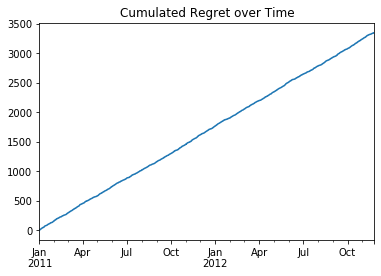

In [89]:
exp = Experiment(n_arms, n_steps).run(EpsilonGreedy(n_arms, epsilon=.1))
print(exp.stochastic_regret_summary())
cumul_data = exp.cumulated_regret_summary()
cumul_data['cumulated_stochastic_regret'].plot(title='Cumulated Regret over Time')

      E[R]  E[Delta]      Rn
0  0.01332   0.99162  1332.0


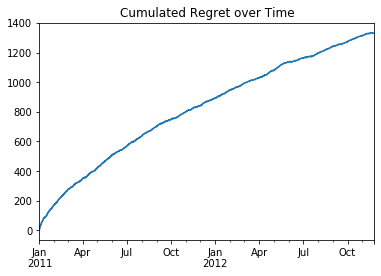

In [90]:
exp = Experiment(n_arms, n_steps).run(UCB(n_arms))
print(exp.stochastic_regret_summary())
cumul_data = exp.cumulated_regret_summary()
cumul_data['cumulated_stochastic_regret'].plot(title='Cumulated Regret over Time')

      E[R]  E[Delta]     Rn
0  0.00242   0.99229  242.0


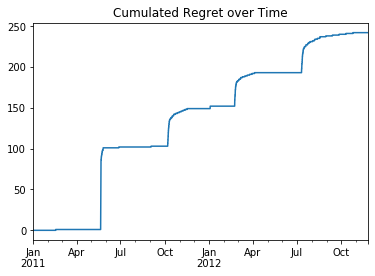

In [99]:
exp = Experiment(n_arms, n_steps, adversarial=5).run(UCB(n_arms))
print(exp.stochastic_regret_summary())
cumul_data = exp.cumulated_regret_summary()
cumul_data['cumulated_stochastic_regret'].plot(title='Cumulated Regret over Time')

your comments